# **Image Classifier**

## Project Content <a id = 0></a>

### First Step: First Organization

1. [Introduction](#1)
2. [Loading libraries and packages to embark our new journey](#2)
3. [Checking The Dataset](#3)
4. [Creating a Data Pypeline and Loading The Dataset](#4)

### Second Step: Data Preprocessing

5. [Scaling The Data](#5)
6. [Seperating Data into Three Parts of Train, Validation and Test Sets](#6)
7. [Categorical Fields Analysis](#7)
8. [Feature Scaling](#8)
9. [Seperating Data into Two Parts of Train and Test](#9)

### Third and Final Step: Modeling

7. [Defining Modeling Functions](#7)
8. [Building The Model's Architecture](#8)
9. [First Time Training](#9)
10. [Plotting The Model's Loss and Accuracy](#10)
11. [Model's Performance Evaluation](#11)
12. [Testing The Model](#12)

***

# First Step: First Organization

***

## 1. Introduction <a id = 1></a>

This analysis is focused on the behavior of telecom customers who are more likely to terminate their contracts.

**Fields**
- Demographic information about customers | **Gender, Seniorcitizen, Partnere, Dependents**
- Main services that each customer has signed up for | **Phoneservice, Multiplelines, Internetservice**
- Internet-based services which customers have signed up for | **Onlinesecurity, Onlinebackup, Deviceprotection, Techsupport, and Streamingtv and streamingmovies**
- Customers' accounts information | **Tenure, Monthlycharges, Totalcharges**
- Customers' financial information | **Contract, Paymentmethod, Paperlessbilling**
- Customers who left within the last month | **Churn**

[Project Content](#0)

## 2. Loading libraries and packages to embark our new journey <a id = 2></a>

In [48]:
# Basic Python Packages
import os
import uuid
import time

# Numpy Library
import numpy as np

# Pandas Library and Settings
import pandas as pd

# Visualization Libraries (Matplotlib, Seaborn)
import matplotlib.pyplot as plt

# Tensorflow Library
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import BinaryAccuracy, Recall, Precision
    
# OpenCV
import cv2
import imghdr

# JSON
import json

%matplotlib inline

[Project Content](#0)

## 3. Collecting Images <a id = 3></a>

In [49]:
images_path = os.path.join("data", "images")

# Images number
m = 30

In [ ]:
# Establish a conncetion with device camera.
capture = cv2.VideoCapture(0)

# Capture the images
for image_num in range(m):
    
    print(f"Collecting the image {image_num}")
    
    ret, frame = capture.read()
    
    image_path = os.path.join(images_path, f"{str(uuid.uuid1())}.jpeg")
    
    cv2.imwrite(image_path, frame)
    cv2.imshow("frame", frame)
    
    time.sleep(1)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
    
capture.release()
cv2.destroyAllWindows()

print("Process finished!")

[Project Content](#0)

## 4. Labeling Images <a id = 4></a>

This step has been done using Labelme software.

## 5. Reviewing Dataset and Building an Image Loading Function <a id = 5></a>

We have to limit the GPU memory growth by tf, since it will use all of the space of VRAM.

In [50]:
gpus = tf.config.experimental.list_physical_devices("GPU")

print("List of GPUS")
print("-"*70)

for gpu in gpus:
    print(f"{gpus.index(gpu)}: {gpu}")

print("\nEnabling Dynamic Allocation of GPU Memory")
print("-"*70)

for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
    print(f"{gpus.index(gpu)}: Dynamic allocation has been enabled.")

List of GPUS
----------------------------------------------------------------------
0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Enabling Dynamic Allocation of GPU Memory
----------------------------------------------------------------------
0: Dynamic allocation has been enabled.


Now it's time to load images into the tensorflow data pypeline.

In [51]:
images = tf.data.Dataset.list_files("data/images/*.jpeg", shuffle=False)

Now, everyhing is fine and we can load and check the images.

In [52]:
def load_image(image_path):
    """
    Reads an image file from the given file path and decodes it into a TensorFlow tensor.

    Args:
        image_path (str): The file path of the image to be loaded.

    Returns:
        decoded_image (tensor): A TensorFlow tensor representing the image.
    """
    
    byte_image = tf.io.read_file(image_path)
    decoded_image = tf.io.decode_jpeg(byte_image)
    
    return decoded_image

Map function will run load image function on each object of the dataset which are passed to pypeline.

In [53]:
images = images.map(load_image)

And the last step before viewing the images is to batching them for model's input.

In [67]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
i = 0

for batch in image_generator:
    
    print(f"Batch {i + 1}: {batch.shape}")
    i += 1

Now we can visualize these images.

* Remember to assign the variable again in order to make the itteration alive.

In [70]:
image_generator = images.batch(4).as_numpy_iterator()

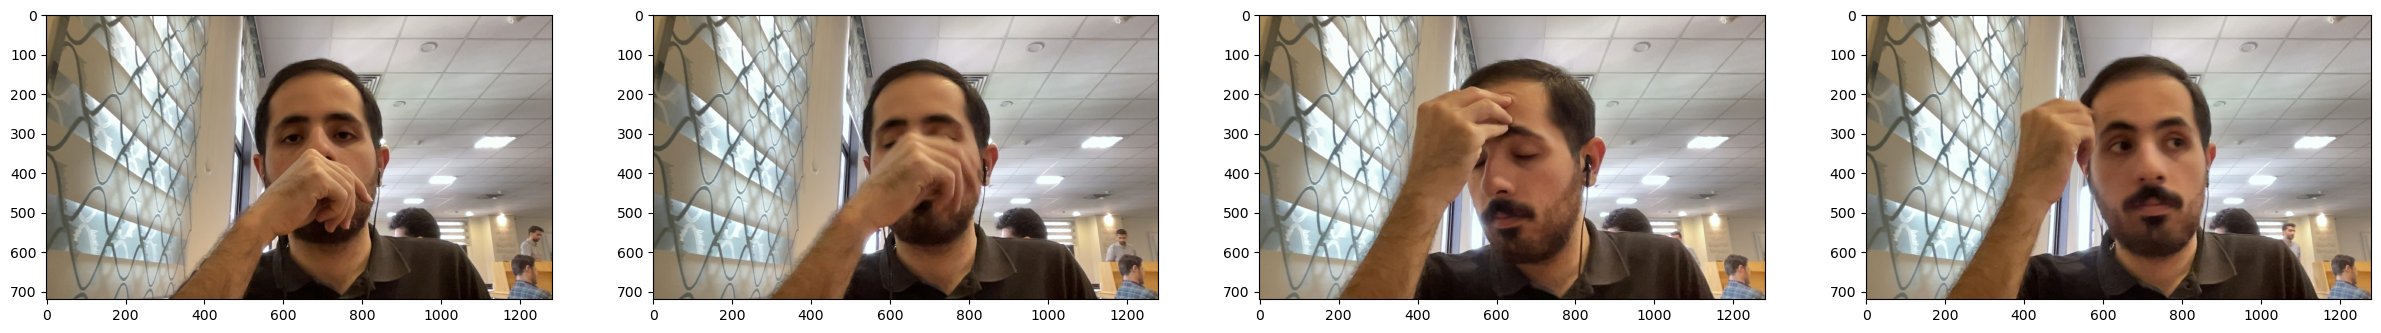

In [72]:
fig, axes = plt.subplots(ncols=4, figsize=(30, 20))

for index, image in enumerate(image_generator.next()):
    axes[index].imshow(image)

[Project Content](#0)

***

# Second Step: Data Preprocessing

***

## 6. Partitioning Unaugmented Data into Three Parts of Train, Validation and Test Sets <a id = 6></a>

***

# Third and Final Step: Modeling

***

## 7. Defining Modeling Functions <a id = 7></a>

## 8. Building The Model's Architecture <a id = 8></a>

## 9. First Time Training <a id = 9></a>

## 10. Plotting The Models's Loss and Accuracy <a id = 10></a>

## 11. Model's Performance Evaluation <a id = 12></a>

## 12. Testing The Model <a id = 12></a>